# Analyzing @LADOTofficial tweets

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import json
import spacy
import sys

import requests
from requests import get

import time 
from time import sleep
import tqdm
from tqdm import trange
from IPython.core.display import clear_output

sys.path.insert(1, 'src/')
import acquire

### Notes:

Hootsuite: https://www.youtube.com/watch?v=Ztk6PXD1EjU

# Twitter API

## Wrangle

In [ ]:
url = "https://api.twitter.com/2/users/17070113/tweets?user.fields=created_at,description,entities,id,location,name,pinned_tweet_id,profile_image_url,protected,public_metrics,url,username,verified&max_results=100&start_time=2020-09-30T00:00:00Z&end_time=2020-10-15T00:00:00Z&expansions=&tweet.fields=created_at,public_metrics,source,text"

payload = {}
headers = {"Authorization": "Bearer {}".format(acquire.create_header())}

response = requests.request("GET", url, headers=headers)
response.status_code

tweets = json.loads(response.text.encode('utf8'))['data']

tweets[1]

data = pd.DataFrame()

for tweet in tweets:
    tweet_data = pd.DataFrame({'post_time': pd.to_datetime(tweet['created_at']),
                               'tweet': tweet['text'].lower(),
                               'retweet_count': tweet['public_metrics']['retweet_count'],
                               'reply_count': tweet['public_metrics']['reply_count'],
                               'like_count': tweet['public_metrics']['like_count'],
                               'quote_count': tweet['public_metrics']['quote_count'],
                               'tweet_url_id': tweet['id']
                               },index=[0])
    data = pd.concat([data, tweet_data])

data = data.sort_values(by=['post_time']).reset_index(drop=True)
data = data.assign(
    total_engagement = data[['retweet_count', 'reply_count', 'like_count', 'quote_count']].sum(axis=1)
)

data.head()

## Putting it all together

In [13]:
tqdm.tqdm_notebook?

In [27]:
twitter_accounts = acquire.acquire_twitter_accounts()

headers = acquire.create_header()
data = pd.DataFrame()

num_accounts = len(twitter_accounts)


for index, account in tqdm.tqdm(twitter_accounts.iterrows(), total=num_accounts):
    url = f"https://api.twitter.com/2/users/{account['id']}/tweets?user.fields=created_at,description"\
        + ",entities,id,location,name,pinned_tweet_id,profile_image_url,protected,public_metrics"\
        + ",url,username,verified&max_results=100&start_time=2020-09-30T00:00:00Z&end_time=2020-10-15T00:00:00"\
        + "Z&expansions=&tweet.fields=created_at,public_metrics,source,text"
    response = requests.request("GET", url, headers=headers)
    sleep(3)

    tweets = json.loads(response.text.encode('utf8'))['data']

    for tweet in tweets:
        tweet_data = pd.DataFrame({'post_time': pd.to_datetime(tweet['created_at']),
                                   'id': account['id'],
                                   'name': account['name'],
                                   'username': account['username'],
                                   'tweet': tweet['text'].lower(),
                                   'retweet_count': tweet['public_metrics']['retweet_count'],
                                   'reply_count': tweet['public_metrics']['reply_count'],
                                   'like_count': tweet['public_metrics']['like_count'],
                                   'quote_count': tweet['public_metrics']['quote_count'],
                                   'tweet_url_id': tweet['id']
                                   },index=[0])
        data = pd.concat([data, tweet_data])

100%|██████████| 5/5 [00:52<00:00, 10.46s/it]


In [28]:
data = data.sort_values(by=['post_time']).reset_index(drop=True)
data = data.assign(
    total_engagement = data[['retweet_count', 'reply_count', 'like_count', 'quote_count']].sum(axis=1)
)

In [29]:
data

,post_time,id,name,username,tweet,retweet_count,reply_count,like_count,quote_count,tweet_url_id,total_engagement
0,2020-09-30 16:02:18+00:00,61261275,Los Angeles Department of Transportation,LADOTofficial,a new bus-only lane is making its debut in #do...,27,9,111,8,1311335571097300996,155
1,2020-09-30 17:37:02+00:00,341250146,Joe Buscaino,JoeBuscaino,rt @bsslosangeles: what a difference it makes ...,3,0,0,0,1311359411806375936,3
2,2020-09-30 17:37:59+00:00,341250146,Joe Buscaino,JoeBuscaino,rt @losangeleswalks: safe streets organizing t...,3,0,0,0,1311359653037527040,3
3,2020-09-30 18:57:42+00:00,17070113,Eric Garcetti,MayorOfLA,rt @citylajobs: the city of la offers an onlin...,17,0,0,0,1311379712439058432,17
4,2020-09-30 19:10:52+00:00,893602974,"Curren D. Price, Jr.",CurrenDPriceJr,i partnered with guardaheart to bring crucial ...,0,0,1,1,1311383024559218688,2
...,...,...,...,...,...,...,...,...,...,...,...
167,2020-10-14 20:30:07+00:00,61261275,Los Angeles Department of Transportation,LADOTofficial,have you registered for the great #california ...,1,3,1,0,1316476400401092608,5
168,2020-10-14 20:56:31+00:00,17070113,Eric Garcetti,MayorOfLA,rt @ladotofficial: ⚠️#reminder ⚠️ parking enfo...,48,0,0,0,1316483045227024384,48
169,2020-10-14 20:56:44+00:00,17070113,Eric Garcetti,MayorOfLA,rt @ladotofficial: #ladot has introduced econo...,14,0,0,0,1316483098570186753,14
170,2020-10-14 20:57:10+00:00,956763276,Nury Martinez,CD6Nury,today marks a seminal moment in la history w/ ...,4,3,7,2,1316483208507080705,16


In [30]:
# data.to_csv('tweets.csv', index=False)

In [31]:
df = pd.read_csv('tweets.csv')

In [32]:
df

,post_time,id,name,username,tweet,retweet_count,reply_count,like_count,quote_count,tweet_url_id,total_engagement
0,2020-09-30 16:02:18+00:00,61261275,Los Angeles Department of Transportation,LADOTofficial,a new bus-only lane is making its debut in #do...,27,9,111,8,1311335571097300996,155
1,2020-09-30 17:37:02+00:00,341250146,Joe Buscaino,JoeBuscaino,rt @bsslosangeles: what a difference it makes ...,3,0,0,0,1311359411806375936,3
2,2020-09-30 17:37:59+00:00,341250146,Joe Buscaino,JoeBuscaino,rt @losangeleswalks: safe streets organizing t...,3,0,0,0,1311359653037527040,3
3,2020-09-30 18:57:42+00:00,17070113,Eric Garcetti,MayorOfLA,rt @citylajobs: the city of la offers an onlin...,17,0,0,0,1311379712439058432,17
4,2020-09-30 19:10:52+00:00,893602974,"Curren D. Price, Jr.",CurrenDPriceJr,i partnered with guardaheart to bring crucial ...,0,0,1,1,1311383024559218688,2
...,...,...,...,...,...,...,...,...,...,...,...
167,2020-10-14 20:30:07+00:00,61261275,Los Angeles Department of Transportation,LADOTofficial,have you registered for the great #california ...,1,3,1,0,1316476400401092608,5
168,2020-10-14 20:56:31+00:00,17070113,Eric Garcetti,MayorOfLA,rt @ladotofficial: ⚠️#reminder ⚠️ parking enfo...,48,0,0,0,1316483045227024384,48
169,2020-10-14 20:56:44+00:00,17070113,Eric Garcetti,MayorOfLA,rt @ladotofficial: #ladot has introduced econo...,14,0,0,0,1316483098570186753,14
170,2020-10-14 20:57:10+00:00,956763276,Nury Martinez,CD6Nury,today marks a seminal moment in la history w/ ...,4,3,7,2,1316483208507080705,16


# Explore

In [33]:
non_enforcement_tweets = data.loc[~df.tweet.str.contains('enforcement')]
enforcement_tweets = data.loc[df.tweet.str.contains('enforcement')]

non_enforcement_metrics = non_enforcement_tweets[['post_time', 'total_engagement']]
enforcement_metrics = enforcement_tweets[['post_time', 'total_engagement']]

non_enforcement_metrics.set_index('post_time', inplace=True)
enforcement_metrics.set_index('post_time', inplace=True)



enforcement_metrics = enforcement_metrics.resample('D').sum()
non_enforcement_metrics = non_enforcement_metrics.resample('D').sum()

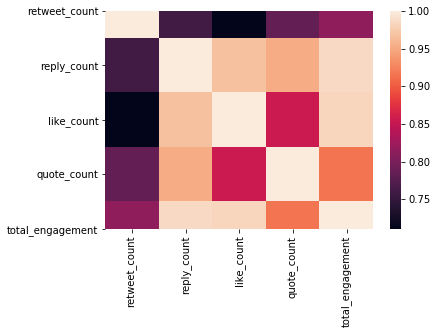

In [34]:
sns.heatmap(enforcement_tweets.corr());

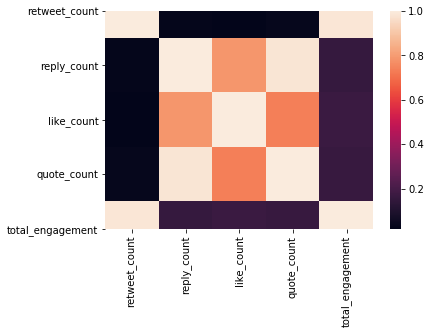

In [35]:
sns.heatmap(non_enforcement_tweets.corr());

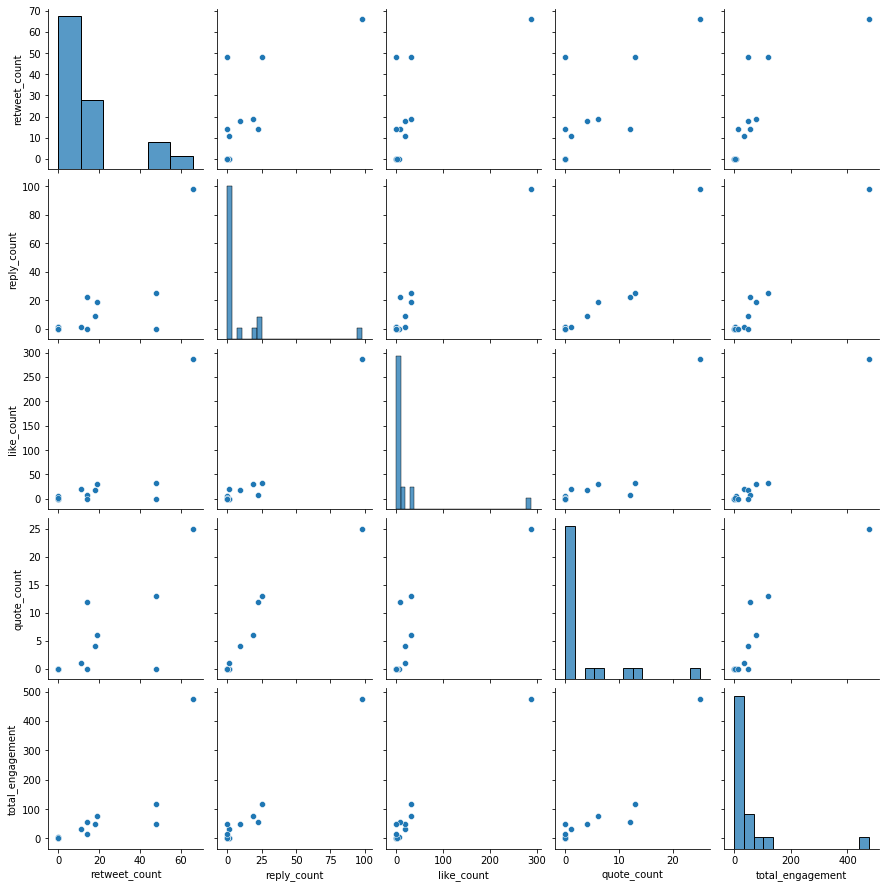

In [36]:
sns.pairplot(enforcement_tweets);

## Tweets from 09-30-2020 through 10-15-2020

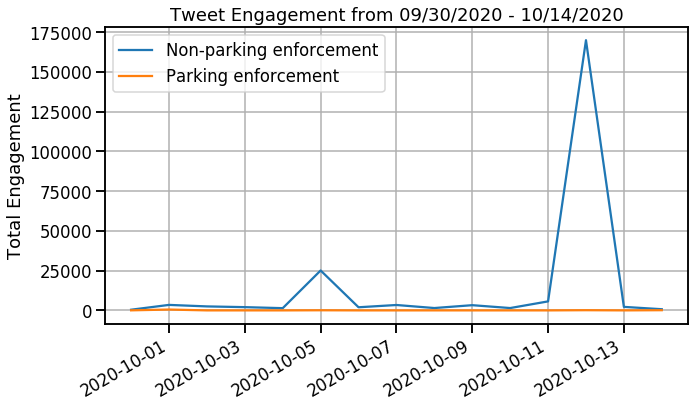

In [37]:
sns.set_context('talk')
plt.figure(figsize=(10, 6))

sns.lineplot(data=non_enforcement_metrics,
             x='post_time',
             y='total_engagement',
             label='Non-parking enforcement')


sns.lineplot(data=enforcement_metrics,
             x='post_time',
             y='total_engagement',
             label='Parking enforcement')


plt.title("Tweet Engagement from 09/30/2020 - 10/14/2020")
plt.xlabel('')
plt.ylabel('Total Engagement')

plt.xticks(rotation=30, ha="right")

plt.grid()
plt.tight_layout();

## Who tweeted the most about parking enforcement?

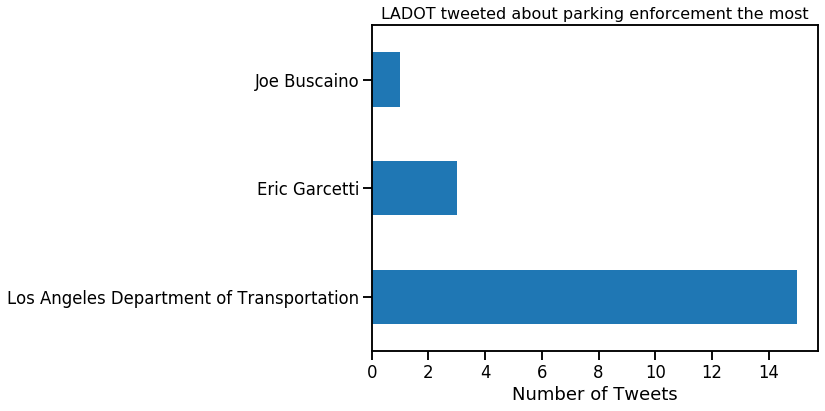

In [38]:
sns.set_context('talk')
enforcement_tweets.groupby('name').size().sort_values(ascending=False).plot.barh(figsize=(8, 6))

plt.title('LADOT tweeted about parking enforcement the most', fontsize=16)
plt.xlabel('Number of Tweets')
plt.ylabel('');

## Who generated the most engagement related to parking enforcement?

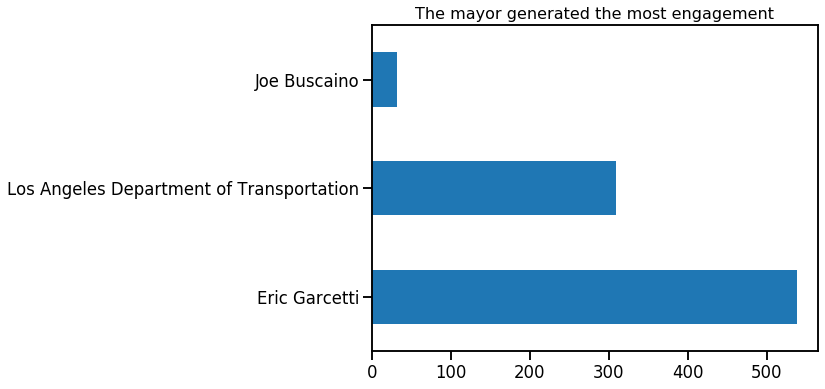

In [39]:
enforcement_tweets.groupby('name').total_engagement.sum().sort_values(ascending=False).plot.barh(figsize=(8, 6))

plt.title('The mayor generated the most engagement', fontsize=16)
plt.ylabel('');

# Appendix

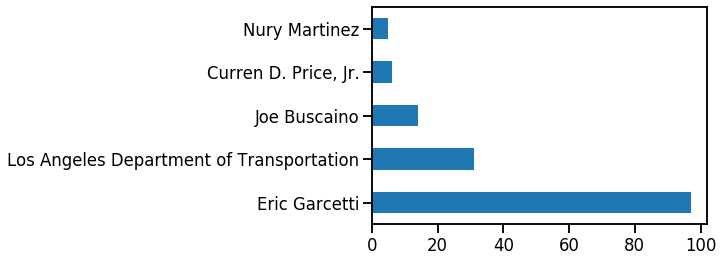

In [40]:
non_enforcement_tweets.groupby('name').size().sort_values(ascending=False).plot.barh()
plt.ylabel('');

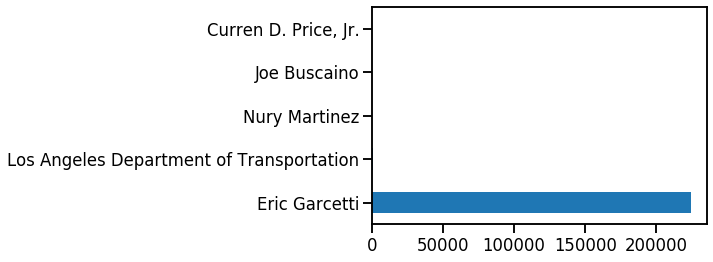

In [41]:
non_enforcement_tweets.groupby('name').total_engagement.sum().sort_values(ascending=False).plot.barh()

plt.ylabel('');

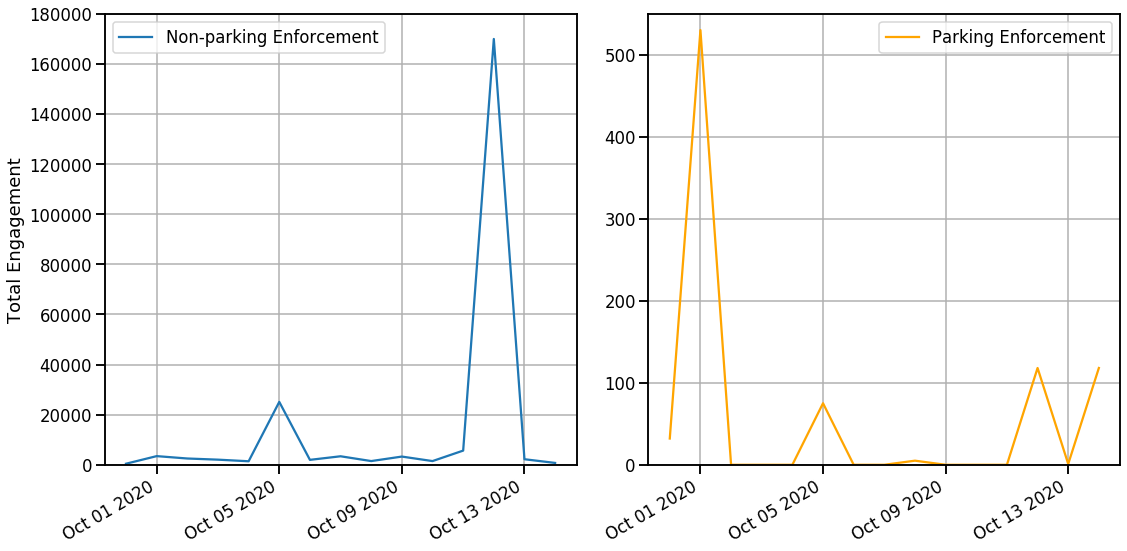

In [42]:
sns.set_context('talk')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

sns.lineplot(data=enforcement_metrics,
             x='post_time',
             y='total_engagement',
             label='Parking Enforcement',
             color='orange',
             ax=ax2)

sns.lineplot(data=non_enforcement_metrics,
             x='post_time',
             y='total_engagement',
             label='Non-parking Enforcement',
             ax=ax1)

ax1.grid()
ax2.grid()

ax1.get_xaxis().set_major_locator(mdates.AutoDateLocator(minticks=3, maxticks=8))
ax1.get_xaxis().set_major_formatter(mdates.DateFormatter("%b %d %Y"))
plt.setp(ax1.get_xticklabels(), rotation=30, ha="right")

ax2.get_xaxis().set_major_locator(mdates.AutoDateLocator(minticks=3, maxticks=8))
ax2.get_xaxis().set_major_formatter(mdates.DateFormatter("%b %d %Y"))
plt.setp(ax2.get_xticklabels(), rotation=30, ha="right")

ax1.set_ylim(0, 180_000)
ax2.set_ylim(0, 550)

ax1.set_xlabel('')
ax2.set_xlabel('')

ax1.set_ylabel('Total Engagement')
ax2.set_ylabel('')

plt.tight_layout();